In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import random, save_npz, load_npz
from functools import partial

from main_algo import splbfgs
from fista import fista
from logistic_setup import f_grad, F

torch.manual_seed(0)
np.random.seed(0)
torch.set_default_dtype(torch.float64)

In [2]:
# generate synthetic data, do not run
n = 10000
d1 = 5000
X1 = torch.randn(n, d1)
y1 = torch.randint(0, 2, (n,))

d = 100000
X2 = random(n, d, density=0.001, format='csr')
X3 = random(n, d, density=0.01, format='csr')


In [ ]:
# save data
torch.save(X1, '../torch_version_sequence/dense_5k.pt')
save_npz('../torch_version_sequence/sparse_10w_0001.npz', X2)
save_npz('../torch_version_sequence/sparse_10w_001.npz', X3)

In [3]:
X1 = torch.load('../torch_version_sequence/dense_5k.pt')
X2 = load_npz('../torch_version_sequence/sparse_10w_0001.npz')
X3 = load_npz('../torch_version_sequence/sparse_10w_001.npz')

In [8]:
L1 = torch.max(torch.norm(X1, dim=1, p=2)**2)
L2 = np.max(np.sqrt(np.asarray(X2.multiply(X2).sum(axis=1)).squeeze()))
L3 = np.max(np.sqrt(np.asarray(X3.multiply(X3).sum(axis=1)).squeeze()))

n1 = X1.shape[0]
n2 = X2.shape[0]
n3 = X3.shape[0]

torch.manual_seed(0)
y1 = torch.randint(0, 2, (n1,))
y2 = torch.randint(0, 2, (n2,))
y3 = torch.randint(0, 2, (n3,))

(L1, L2, L3)

(10000,)

In [11]:
# use fista to derive optimal values, do not run it again!

# set lambda and mu
lam = 1e-3
mu = 1e-3

# define grad_function given dataset X, y, mu
grad1 = partial(f_grad, X=X1, y=y1, mu=mu)
grad2 = partial(f_grad, X=X2, y=y2, mu=mu)
grad3 = partial(f_grad, X=X3, y=y3, mu=mu)

# Apply FISTA to solve the original problem
x_init_1 = 0.01 * torch.ones(X1.shape[1])
x_init_2 = 0.01 * torch.ones(X2.shape[1])
x_init_3 = 0.01 * torch.ones(X3.shape[1])

options = {'stopping': '', 'threshold': 1e-10, 'max_iter': 10000, 'store_seq': False}

x_1_opt, _ = fista(grad1, L1, lam, x_init_1, options)
x_2_opt, _ = fista(grad2, L2, lam, x_init_2, options)
x_3_opt, _ = fista(grad3, L3, lam, x_init_3, options)

loss_1_opt = F(x_1_opt, X1, y1, mu, lam)
loss_2_opt = F(x_2_opt, X2, y2, mu, lam)
loss_3_opt = F(x_3_opt, X3, y3, mu, lam)

np.savez('../torch_version_sequence/synthetic_10000_optimal.npz', x1=x_1_opt, x2=x_2_opt, x3=x_3_opt, loss1=loss_1_opt, loss2=loss_2_opt, loss3=loss_3_opt)

In [13]:
p = 0.01
lam = 1e-3
mu = 1e-3

x_init_1 = 0.01 * torch.ones(X1.shape[1])
x_init_2 = 0.01 * torch.ones(X2.shape[1])
x_init_3 = 0.01 * torch.ones(X3.shape[1])

In [16]:
loss, para, info = splbfgs(X=X2, y=y2, b=256, bH=600, M=10, L=10, alpha=0.02, prob=p, w=x_init_2, n_epochs=100, lam=lam, mu=mu, optimizer='ssn')

100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


In [17]:
info

[2.78212308883667, 6.2875, 58, 18.413793103448278, 0]

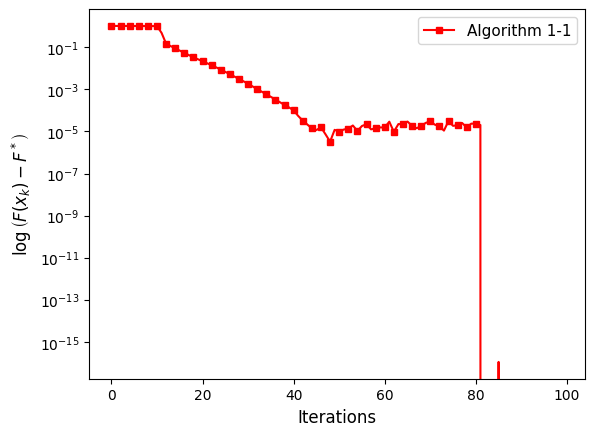

In [20]:
plt.plot(loss-loss_2_opt, label=f'Algorithm 1-1', color='r', marker='s', markersize=5, markevery=2)
plt.legend(fontsize=11)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel(r'$\log\left(F(x_k)-F^*\right)$', fontsize=12)
plt.show()